# Working with an existing corpus

In this notebook, we will work with an existing corpus, in csv format, to draw information from it and do some basic operations with spaCy.

Go back to the `00_spacy_intro.ipynb` notebook for an intro to spaCy and for information on how to iterate through tokens and lemmas. 

Here, we will work with larger texts, to either create a corpus or work with one that already exists. In the `data/` directory, there is a file called `gnm_articles.csv` that you'll need. 

Acknowledgements: [Tuomo Hiippala](https://www.mv.helsinki.fi/home/thiippal/), [Programming Historian](https://programminghistorian.org/), [Melanie Walsh](https://melaniewalsh.github.io/Intro-Cultural-Analytics/welcome.html).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import os
import re
from pprint import pprint
import spacy
nlp = spacy.load('en_core_web_sm')

## Working with a csv file

We will first work with a single file, a part of the [SFU Opinion and Comments Corpus (SOCC)](https://github.com/sfu-discourse-lab/SOCC). The corpus was collected in our lab, the Discourse Processing Lab, for a project on evaluative language in online news comments. It consists of: opinion articles, comments, and annotated comments from the Canadian newspaper _The Globe and Mail_. We'll work with the articles, which should be in the data directory. If not, you can always download the corpus directly from the page above or from its [Kaggle page](https://www.kaggle.com/datasets/mtaboada/sfu-opinion-and-comments-corpus-socc) and save the `gnm_articles.csv` file to your data directory. 

We will first read the csv file into a pandas dataframe, `socc_df`. You can find out more about the contents of the file with the pandas function `shape()`. Then, we'll print the first few rows and find out what the headers are. 

In [2]:
# read the csv file into a pandas dataframe

socc_df = pd.read_csv('data/gnm_articles.csv', encoding='utf-8')

In [3]:
# store the number of rows and columns and print them

nRow, nCol = socc_df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 10339 rows and 8 columns


In [4]:
# print the first 5 rows

socc_df.head(5)

,article_id,title,article_url,author,published_date,ncomments,ntop_level_comments,article_text
0,26842506,The Tories deserve another mandate - Stephen H...,http://www.theglobeandmail.com/opinion/editori...,GLOBE EDITORIAL,2015-10-16 EDT,2187.0,1378.0,<p>All elections are choices among imperfect a...
1,26055892,Harper hysteria a sign of closed liberal minds,http://www.theglobeandmail.com/opinion/harper-...,Konrad Yakabuski,2015-08-24 EDT,1103.0,455.0,<p>If even a fraction of the darkness that his...
2,6929035,Too many first nations people live in a dream ...,http://www.theglobeandmail.com/opinion/too-man...,Jeffrey Simpson,2013-01-05 EST,1164.0,433.0,<p>Large elements of aboriginal Canada live in...
3,19047636,The Globe's editorial board endorses Tim Hudak...,http://www.theglobeandmail.com/opinion/editori...,GLOBE EDITORIAL,2014-06-06 EDT,905.0,432.0,"<p>Over four days, The Globe editorial board l..."
4,11672346,Disgruntled Arab states look to strip Canada o...,http://www.theglobeandmail.com/news/world/disg...,Campbell Clark,2013-05-02 EDT,1129.0,411.0,<p>Growing discontent among Arab nations over ...


## Information about the dataframe

From the `shape()` information, we know that the file has 10,339 rows. That is one article per row, with information about the title of the article, the author, the date of publication and the number of comments it received. The comments are stored in a separate file in the [SOCC corpus](https://github.com/sfu-discourse-lab/SOCC).  

We can examine the pandas dataframe and figure out, for instance, how many comments articles got. `ncomments` is the number o total comments an article received.  `ntop_level_comments` is how many of them were beginnings of threads (as opposed to replies). 

You can use `value_counts()` to list characteristics of various columns. Here, we'll do `ncomments` and `author`. I also use `describe()` to give me statistics of how many columns there are, the average, min and max, etc. Note the difference between the output for `describe()` for the comments and for the authors, as the former contains numbers and the latter, strings. 

You can also get the same information in a bar chart, which here I am limiting to the top 10 categories. But you can change that parameter (`value_counts()[:10]`) to get more bars. Note: if the `.plot()` cells don't show you a bar chart, run them again. 

In [5]:
socc_df['ncomments'].value_counts()

0.0       2542
1.0        186
3.0        171
2.0        161
6.0        132
          ... 
458.0        1
539.0        1
312.0        1
1164.0       1
592.0        1
Name: ncomments, Length: 516, dtype: int64

In [6]:
socc_df['ncomments'].describe()

count    10339.000000
mean        64.142857
std        101.565870
min          0.000000
25%          1.000000
50%         25.000000
75%         83.500000
max       2187.000000
Name: ncomments, dtype: float64

In [7]:
socc_df['author'].value_counts()

GLOBE EDITORIAL                    2712
Jeffrey Simpson                     649
Margaret Wente                      547
Konrad Yakabuski                    404
Gary Mason                          365
                                   ... 
Dany Assaf and Lisa Assaf             1
Carmen Cheung and Samer Muscati       1
Ross Finnie and Richard Mueller       1
David Clayton-Thomas                  1
Fred Abrahams                         1
Name: author, Length: 1896, dtype: int64

In [8]:
socc_df['author'].describe()

count               10339
unique               1896
top       GLOBE EDITORIAL
freq                 2712
Name: author, dtype: object

<AxesSubplot:>

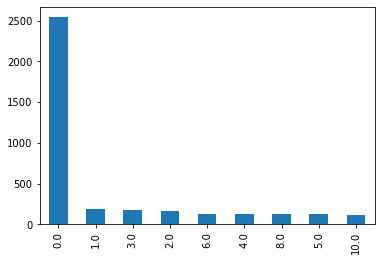

In [9]:
socc_df['ncomments'].value_counts()[:10].plot(kind='bar')

<AxesSubplot:>

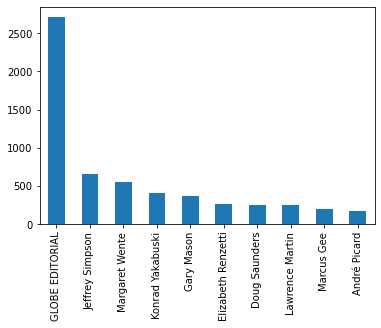

In [10]:
socc_df['author'].value_counts()[:10].plot(kind='bar')

## Explore articles with many and with zero comments

We are going to compare articles that have many comments to those that have none. Let's take a random sample of 100 of each and do a few comparisons.

As you saw above, the average number of comments is 64. So let's use that number as the cut-off for articles with many comments. 

We first copy a part of the original data frame into a new one, selecting only rows where the count of ncomments is higher than 64. If you are curious, that gives us 3,179 articles, with a large spread of how many comments each has. We take a random sample of 100 from those and put the value of the `article_text` column into a string, `many_comments`. 

Then, we do exactly the same for articles with 0 comments and put them into a different string, `zero_comments`. There are 2,542 articles with zero comments. 

In [11]:
# get all the articles with >64 into a df, then take a random sample of that frame
# finally, put the article_text column for those into a string

many_comments_df = socc_df[socc_df['ncomments'] > 64]
sample_many_comments_df = many_comments_df.sample(n=100) 
many_comments = ", ".join(sample_many_comments_df['article_text'])

In [12]:
many_comments_df['ncomments'].describe()

count    3179.000000
mean      173.049701
std       125.065398
min        65.000000
25%        92.000000
50%       133.000000
75%       212.000000
max      2187.000000
Name: ncomments, dtype: float64

In [13]:
many_comments_df['ncomments'].value_counts()

67.0     42
80.0     38
68.0     38
69.0     38
71.0     38
         ..
519.0     1
517.0     1
418.0     1
351.0     1
796.0     1
Name: ncomments, Length: 451, dtype: int64

In [14]:
# get all the articles with 0 comments into a df, then take a random sample of that frame
# finally, put the article_text column for those into a string

zero_comments_df = socc_df[socc_df['ncomments'] == 0]
sample_zero_comments_df = zero_comments_df.sample(n=100) 
zero_comments = ", ".join(sample_zero_comments_df['article_text'])

In [15]:
zero_comments_df['ncomments'].describe()

count    2542.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: ncomments, dtype: float64

## Data cleanup and analysis

We have two string variables, `many_comments` and `zero_comments` (hint: if you get tired of typing variable names, you can start typing, hit "tab" and it will autocomplete.)

The first thing we are going to do is look at the strings. You can check how long they are (this will be in characters) and print them, to see if they have any code we don't want. You'll see that there are `<p>` and `</p>` tags. Those are html paragraph marks, and we don't need them. So our first task is exciting: We'll define our first function! You'll see the line that starts with `def`. That's a function definition in python. We use the `re`, regular expression module, to find all the things between angle brackers, and replace them with nothing. Then, print the text again to see if they are gone.

In [16]:
len(many_comments)

441698

In [17]:
len(zero_comments)

401411

In [18]:
print(many_comments)

<p>'Global growth will be disappointing and uneven in 2016.' That was the prediction last week of Christine Lagarde, managing director of the International Monetary Fund.</p><p>Alas, Ms. Lagarde quite likely underestimated how disappointing and uneven world growth will be in 2016, to say nothing of Canada's very dispiriting economic prospects.</p>, <p>Tony Keller is Globe and Mail editorial page editor.</p><p>If poll after poll is to be believed, Jim Prentice is about to pull off an historic first: He is about to become the first Alberta Progressive Conservative premier to lose an election since the Early Paleolithic era. The reasons are many and have been widely discussed: His predecessors left him far more than the allotted limit of political carry-on baggage. His sensible budget of mild spending cuts and slightly higher taxes - but not on corporations - succeeded in galvanizing opposition on both sides of the spectrum. His supposed masterstroke of luring the bulk of the Wildrose off

In [19]:
print(zero_comments)

<p>The federal Conservatives' reported intention to introduce a bill to enable individual aboriginals living on a reserve to acquire and own land on that reserve, if the first nation in question opts in to such a regime, is a welcome step forward.</p><p>Not many native leaders are now in favour of such a change, but if a few communities were to thrive as a result of the new legislation, opinion would probably shift.</p><p>The Conservatives' election platform of 2006 promised to 'support the development of individual property ownership of reserves, to encourage lending for private housing and business.' Their platforms in 2008 and 2011 were less clear. But after a year of majority government, they seem poised to act on a six-year-old plank.</p><p>There may be clues to the contents of the future bill in a book published in 2010, Beyond the Indian Act: Restoring Aboriginal Property Rights, by Tom Flanagan (a political science professor who was the Conservatives' campaign manager in 2004),

In [20]:
# Define an HTML tag removal function

def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [21]:
many_clean = remove_html_tags(many_comments)
zero_clean = remove_html_tags(zero_comments)

In [22]:
print(many_clean)

'Global growth will be disappointing and uneven in 2016.' That was the prediction last week of Christine Lagarde, managing director of the International Monetary Fund.Alas, Ms. Lagarde quite likely underestimated how disappointing and uneven world growth will be in 2016, to say nothing of Canada's very dispiriting economic prospects., Tony Keller is Globe and Mail editorial page editor.If poll after poll is to be believed, Jim Prentice is about to pull off an historic first: He is about to become the first Alberta Progressive Conservative premier to lose an election since the Early Paleolithic era. The reasons are many and have been widely discussed: His predecessors left him far more than the allotted limit of political carry-on baggage. His sensible budget of mild spending cuts and slightly higher taxes - but not on corporations - succeeded in galvanizing opposition on both sides of the spectrum. His supposed masterstroke of luring the bulk of the Wildrose official opposition over to

In [23]:
len(many_clean)

432528

In [24]:
len(zero_clean)

392031

## spaCy

We use spaCy to analyze the text. That'll give us tokens, POS, NER, etc. Go back to the `spacy_intro.ipynb` for information on the kind of information you can get from the spCy pipeline. I have given you just some examples again here. 

In [25]:
many_doc = nlp(many_clean)

In [26]:
zero_doc = nlp(zero_clean)

In [27]:
# some of the things from the other spacy notebook
# I print only the first 20 tokens in many_doc

for token in many_doc[:20]:
    print(token.text, token.pos_)

' PUNCT
Global ADJ
growth NOUN
will AUX
be AUX
disappointing ADJ
and CCONJ
uneven ADJ
in ADP
2016 NUM
. PUNCT
' PUNCT
That PRON
was AUX
the DET
prediction NOUN
last ADJ
week NOUN
of ADP
Christine PROPN


In [28]:
# print the entities in the first 50 tokens of zero_doc

for ent in zero_doc[:50].ents:
    print(ent.text, ent.label_)

Conservatives NORP
first ORDINAL


## Compare many and zero articles

Think about what can make an article have many or no comments. Could it be the topics discussed? The author of the article? The people/places being discussed? We can try and compare these two very small samples using the information that spaCy provides and the information from the articles. 

The first comparison is not linguistic really, but about authors. Check which are the top 4-5 authors in each data sample and if they are significantly different. Note that, because we are taking a random sample from the `many_comments_df` and `zero_comments_df` every time we run this notebook, the results will change every time. You could also do this analysis on the full sample of each type. 

The next analysis compares the number of words and number of sentences in each sample (tokens in the article body). Are there differences? In my case, `many_doc` tends to have more tokens and sentences than `zero_doc`. 

Then, we are going to examine entities. One first analysis creates a dictionary and iterates through the list of entities, to see which entities are more frequent. We do the same for articles with zero comments. These will be long dictionaries, so it may be hard to find any differences. The next thing we do is to create lists of _types_ of entites, rather than the entities themselves. Do you see any differences? What are the top entities and top entity types in each corpus?

In [29]:
sample_many_comments_df['author'].value_counts()

Margaret Wente                        14
GLOBE EDITORIAL                       14
Jeffrey Simpson                       12
Elizabeth Renzetti                     8
Konrad Yakabuski                       5
Lawrence Martin                        5
Lysiane Gagnon                         3
Marcus Gee                             2
Michael Bell                           2
André Picard                           2
Doug Saunders                          2
TONY KELLER                            2
Paul Heinbecker                        2
Tabatha Southey                        2
John Ibbitson                          1
Richard Wagamese                       1
IAN BURUMA                             1
GORDON GIBSON                          1
SARAH KENDZIOR                         1
Signa Daum Shanks and Adam Dodek       1
Naila Keleta-Mae                       1
Preston Manning                        1
SHARI GRAYDON                          1
PETER JONES                            1
Brian Goldman   

In [30]:
sample_zero_comments_df['author'].value_counts()

GLOBE EDITORIAL         20
Jeffrey Simpson          6
Margaret Wente           6
TOM HAWTHORN             4
John Ibbitson            4
Adam Radwanski           3
STEPHEN QUINN            3
Neil Reynolds            2
ROBERT MATAS             2
Mark Hume                2
Doug Saunders            2
Brent Jang               2
Campbell Clark           2
Gary Mason               2
MARK SCHATZKER           2
Justine Hunter           2
Neil Boyd                1
Colin Kenny              1
SYLVAIN CHARLEBOIS       1
Michael Bell             1
Doug Steiner             1
Dalton McGuinty          1
STEVE TUSTIN             1
Michael Thompson         1
Philip Howard            1
SHEEMA KHAN              1
Jody Wilson-Raybould     1
William Robson           1
CHRISTY CLARK            1
Paul S. Appelbaum        1
TIMOTHY CAULFIELD        1
ALFRED APPS              1
IRVIN STUDIN             1
WALLER NEWELL            1
Stephen Gordon           1
Antonia Maioni           1
Marcus Gee               1
P

In [31]:
print("Tokens in articles with many comments:", len(many_doc))

Tokens in articles with many comments: 84330


In [32]:
print("Sentences in articles with many comments:", len(list(many_doc.sents)))

Sentences in articles with many comments: 3710


In [33]:
print("Tokens in articles with zero comments:", len(zero_doc))

Tokens in articles with zero comments: 75607


In [34]:
print("Sentences in articles with zero comments:", len(list(zero_doc.sents)))

Sentences in articles with zero comments: 3242


In [35]:
# create a dictionary to store the entities in the many_comments articles

many_ent_dict = {}

# iterate through the list of entities and increase the count every time
# we see the same text

for ent in many_doc.ents:
    many_ent_dict[ent.text] = many_ent_dict.get(ent.text, 0) + 1

# you can print many_ent_dict now, but it's not in sorted order
# instead, create a sorted version of the dictionary and print that

many_ent_dict_sorted = sorted(many_ent_dict.items(), key=lambda item: item[1], reverse=True)

print("Entities in articles with many comments:")
for ent, count in many_ent_dict_sorted:
    print(ent, count)

Entities in articles with many comments:
Canada 165
one 77
Canadian 68
Trudeau 68
Quebec 62
U.S. 59
Trump 58
first 53
Conservatives 53
French 52
Harper 52
Senate 49
two 48
Toronto 46
Canadians 45
Israel 40
the United States 36
Ontario 36
Liberals 31
Ottawa 30
Justin Trudeau 28
Iraq 27
three 26
Conservative 25
Israeli 23
Obama 23
Arab 22
second 21
Europe 21
Stephen Harper 20
English 20
Ford 20
American 19
Liberal 18
last week 17
NDP 17
Jews 17
Republican 17
Alberta 16
France 16
UN 16
Palestinian 16
today 15
Americans 14
Russia 14
Republicans 14
European 13
Paris 13
China 13
this week 12
2011 12
CBC 12
One 12
Syria 12
Vancouver 12
Jewish 12
Washington 12
PISA 11
Duffy 11
Bachelor 10
First 10
Islamic 10
Today 10
Turkey 10
Erdogan 10
Monday 9
Donald Trump 9
2012 9
Arctic 9
GOP 9
British 9
Putin 9
Couillard 9
Jerusalem 9
Snowden 9
third 8
millions 8
years 8
Stephen Harper's 8
Jean Chretien 8
Rob Ford 8
the Middle East 8
Tims 8
2013 8
Black 8
Democrats 8
APTA 8
six 8
half 8
Israelis 8
J.J. 8

NAFTA 1
Oct. 12 1
Buy American 1
Energy East 1
Sugar Ray Leonard 1
Naila Keleta-Mae 1
the University of Waterloo 1
30 minute 1
afternoon 1
Honour Group 1
LGBTQ 1
the Allen Expressway 1
Toronto Police Services 1
Blockorama 1
Pride 1
1981 1
150 1
more than 300 1
Thirty-five years later 1
the months and years 1
Jian Ghomeshi 1
a night 1
Kathryn Wells 1
2013-14 1
the latest year 1
3,002 1
1,626 1
1,357 1
269 1
all.5 1
the National Capital Commission 1
Larry Beasley 1
the Royal Architectural Institute of Canada 1
the Ontario Association of Architects 1
NDP MPs 1
Seventeen 1
the Canadian Bar Association 1
Poles 1
Ukrainians 1
Czechs 1
Hungarians 1
Baltic 1
diaspora histories 1
Bill C-51 1
the Fair Elections Act 1
Islamists 1
Charlie Coulibaly 1
Amedy Coulibaly 1
neo-Nazi 1
Manuel Valls 1
Saturday 1
Jeffrey Goldberg 1
North Africa 1
about 500,000 1
Mohammed Merah 1
the Jewish Museum 1
Last summer 1
pro-Palestinian 1
Sarcelles 1
Le Marais 1
Thousands 1
Egyptian 1
Abdel Fattah 1
el-Sisi 1
New Y

In [36]:
# do the same for zero_comments

zero_ent_dict = {}

for ent in zero_doc.ents:
    zero_ent_dict[ent.text] = zero_ent_dict.get(ent.text, 0) + 1

zero_ent_dict_sorted = sorted(zero_ent_dict.items(), key=lambda item: item[1], reverse=True)

print("Entities in articles with zero comments:")
for ent, count in zero_ent_dict_sorted:
    print(ent, count)

Entities in articles with zero comments:
Canada 158
Canadian 86
one 64
Alberta 54
Canadians 52
two 50
first 46
U.S. 43
Toronto 43
Ontario 43
Vancouver 38
Liberals 36
Quebec 35
B.C. 34
Conservatives 31
Ottawa 31
Clark 23
NDP 22
Romney 20
McGuinty 20
three 19
Obama 18
this week 17
British Columbia 17
last week 16
Americans 16
Victoria 16
Liberal 15
Senate 15
China 15
Enbridge 15
the United States 14
years 14
today 13
five 13
American 13
One 12
six 12
Stephen Harper 12
Iran 12
Redford 11
Chinese 11
Democrats 11
Republicans 10
four 10
Barack Obama 10
Wisconsin 10
Harper 10
TTC 10
Janion 10
Muslim 9
Mitt Romney 9
British Columbians 9
Twitter 9
Dalton McGuinty 9
Drummond 9
Europe 9
2 9
this year 9
Parliament 9
Syria 9
Fieri 9
2010 8
Asia 8
Republican 8
America 8
half 8
Conservative 8
Montreal 8
Britain 8
Thursday 8
Christy Clark 8
10 8
last year 8
Alison Redford 8
Vancouver Island 8
New York 8
Dunbar 8
Israel 8
Mulcair 8
Bryce 8
Breivik 8
2008 7
decades 7
Monday 7
Today 7
Stephen Harper's 7


Wednesday 1
West End 1
Peter Jepson-Young 1
a week 1
two years 1
96 per cent 1
Peter Centre's 1
10 years ago 1
the College of Registered Nurses 1
Saturdays 1
late spring 1
nearly $1-million 1
100-plus 1
'Maxine Davis 1
Peter AIDS Foundation 1
last April 1
Banff National Park 1
Tim Hortons 1
Sun News ' 1
last October 1
the Ministry of Citizenship and Immigration 1
Sun Media 1
Pat Bolland 1
the Royal Family 1
the end of this weekend 1
TSN 1
six-month 1
Ellen Page 1
Lester B. Pearson 1
Michael Fullan 1
the Learning Partnership Education Summit 1
Tony Blair's 1
$14-billion 1
Mike Harris 1
the Global Commission on Drug Policy 1
Mexican 1
Felipe Calderon's 1
El Salvador 1
Honduras 1
25 per cent 1
Guinea Bissau 1
Cocaine 1
Narco 1
George Bush 1
Dick Cheney 1
Ron Paul 1
Michael Moore 1
Thomas Jefferson 1
Theodore Roosevelt's 1
Woodrow Wilson 1
Harry Truman 1
JFK 1
LBJ 1
Vietnam 1
George McGovern 1
Jimmy Carter 1
Elliot Abrams 1
Paul Wolfowitz 1
Richard Nixon 1
Ronald Reagan 1
Bill Clinton 1
Ge

In [37]:
# now, instead of the entities themselves, we are going to compare entity types
many_ent_types = {}

for ent in many_doc.ents:
    many_ent_types[ent.label_] = many_ent_types.get(ent.label_, 0) + 1

print("Entity types in articles with many comments:")
for ent, count in many_ent_types.items():
    print(ent, count)

Entity types in articles with many comments:
DATE 606
PERSON 1158
ORG 828
GPE 895
ORDINAL 110
EVENT 18
NORP 646
CARDINAL 441
LAW 18
TIME 46
WORK_OF_ART 25
QUANTITY 8
MONEY 93
LOC 96
PRODUCT 13
FAC 15
LANGUAGE 37
PERCENT 2


In [38]:
# same for articles with zero comments
zero_ent_types = {}

for ent in zero_doc.ents:
    zero_ent_types[ent.label_] = zero_ent_types.get(ent.label_, 0) + 1

print("Entity types in articles with zero comments:")
for ent, count in zero_ent_types.items():
    print(ent, count)

Entity types in articles with zero comments:
NORP 452
ORDINAL 72
DATE 609
ORG 779
PERSON 897
FAC 42
GPE 966
CARDINAL 411
MONEY 138
LOC 97
WORK_OF_ART 12
EVENT 22
PRODUCT 17
LAW 16
TIME 37
QUANTITY 25
LANGUAGE 6
PERCENT 2


## Comparing top words and top POS

What are the most frequent words, most frequent nouns, verbs, etc? Most frequent POS? To do this, it's best to work with the lemmatized versions, because then we can count _think, thought,_ and _thinking_ as instances of the same lemma, _think_. 
We will also use another tool, a list of [stop words](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html), so that we don't count frequent function words such as _the, and, of_. There are many such lists for English, depending on what you are interested in counting. The full list from spaCy is available on [spaCy's GitHub](https://github.com/explosion/spaCy/blob/master/spacy/lang/en/stop_words.py). We also exclude anything that is not a word, i.e., punctuation and numbers. These are the steps in the for loop to count lemmas:

* First, check if it's an alpha type of token
* Then, check that it is not a stop word
* Lowercase the lemma
* Add to the count of lemmas

The next two code blocks count noun chunks, i.e., noun phrases. 

Then, we are going to work with POS tags. I'll do those in a separate section, because I also want to include plots and functions there. 

In [39]:
many_lemma_counts = {}
many_lemma_total = 0

for token in many_doc:
    if token.is_alpha and not token.is_stop:
        lemma = token.lemma_.lower()
        many_lemma_counts[lemma] = many_lemma_counts.get(lemma, 0) + 1
        many_lemma_total = many_lemma_total + 1
        
many_lemma_counts_sorted = sorted(many_lemma_counts.items(), key=lambda item: item[1], reverse=True)

print("Total lemma count: ", many_lemma_total)
print("Lemmas in the many comments:")
for lemma, count in many_lemma_counts_sorted:
    print(lemma, count)

Total lemma count:  34487
Lemmas in the many comments:
canada 208
government 183
people 160
year 156
say 124
time 123
new 123
like 118
minister 115
party 114
trudeau 112
woman 106
know 106
long 103
good 101
harper 100
change 92
come 90
right 89
election 88
way 87
canadian 86
country 86
public 85
go 85
work 84
think 83
cent 81
conservative 80
political 78
policy 76
child 75
trump 75
need 73
leader 72
prime 72
man 71
state 71
take 71
quebec 71
toronto 70
world 67
want 67
week 66
tell 66
high 61
thing 60
find 59
liberal 59
mean 58
look 56
case 56
life 55
old 55
call 54
city 54
ontario 54
school 54
medium 53
french 53
police 53
leave 52
ask 52
try 52
voter 50
happen 50
question 50
feel 50
senate 50
power 49
conservatives 49
united 49
big 49
lot 48
day 48
group 48
law 47
kid 47
issue 47
cost 47
end 46
canadians 45
hard 45
force 45
lose 44
point 44
include 44
young 44
system 44
war 44
court 44
far 43
write 43
line 43
term 42
states 42
month 41
bad 41
well 41
use 41
care 41
help 41
problem 41

struggle 6
francophone 6
ill 6
chinese 6
controversial 6
tactic 6
feature 6
miss 6
understanding 6
hot 6
prominent 6
management 6
mental 6
physical 6
behavioural 6
notion 6
scientist 6
belong 6
difficulty 6
tories 6
judgment 6
parliamentary 6
offence 6
slowly 6
secret 6
profession 6
attitude 6
cite 6
jurisdiction 6
d 6
fit 6
regime 6
local 6
neglect 6
comfortable 6
welcome 6
card 6
perform 6
block 6
award 6
kurdish 6
successfully 6
suspend 6
services 6
bhabha 6
civilian 6
degree 6
regard 6
sentence 6
table 6
town 6
researcher 6
mackenzie 6
mike 6
german 6
meantime 6
quo 6
push 6
occupy 6
eastern 6
fundamental 6
objective 6
lay 6
estimate 6
account 6
persuade 6
sale 6
conference 6
ted 6
expensive 6
violent 6
principal 6
weapon 6
outrage 6
smoke 6
rightly 6
precisely 6
efficient 6
memory 6
unfair 6
municipal 6
effectively 6
minor 6
toll 6
bold 6
ed 6
subsidy 6
luck 6
mom 6
rarely 6
emergency 6
vast 6
humanity 6
necessary 6
analysis 6
constantly 6
educator 6
traditional 6
remake 6
launch 

illicit 3
user 3
bed 3
division 3
highlight 3
meitiv 3
architecture 3
gaga 3
buyer 3
mayrand 3
gore 3
anticosti 3
arithmetic 3
kumon 3
crucifix 3
abu 3
khdeir 3
ultra 3
gattuso 3
fashioned 3
sexually 3
jam 3
disappointing 2
uneven 2
prediction 2
lagarde 2
alas 2
underestimate 2
keller 2
baggage 2
mild 2
spectrum 2
infuriate 2
albertans 2
genius 2
crossing 2
painfully 2
october 2
wealthy 2
unhappy 2
realization 2
likeable 2
voluntarily 2
season 2
blockbuster 2
shy 2
soules 2
prince 2
swim 2
mud 2
amazing 2
devolve 2
journey 2
leverage 2
suite 2
compatibility 2
eyelash 2
hugely 2
comforting 2
disturbing 2
wonderfully 2
happily 2
rose 2
feminism 2
ideologically 2
lifelong 2
variety 2
oral 2
healing 2
dance 2
empowerment 2
drain 2
daycare 2
collage 2
decorate 2
concentrate 2
flag 2
session 2
photograph 2
elder 2
accomplish 2
sad 2
dysfunctional 2
ingrained 2
flare 2
richard 2
sarah 2
terrify 2
fascist 2
vernacular 2
bemoan 2
facilitate 2
distinction 2
intentional 2
bait 2
manifold 2
hallma

incapable 1
gerry 1
l 1
rhodes 1
mist 1
infantilize 1
crone 1
nighttime 1
newscast 1
earthquake 1
jolt 1
lately 1
crusade 1
loomsanalysis 1
factoropinion 1
raffarin 1
thesis 1
madame 1
frexit 1
bankable 1
republicains 1
bearer 1
alain 1
nicolas 1
polar 1
flagging 1
hyperactive 1
improbably 1
xenophobic 1
diatribe 1
renegotiate 1
vocally 1
bombastic 1
consecutive 1
underscore 1
demagoguery 1
hauntingly 1
fateful 1
beige 1
sheet 1
fiery 1
notary 1
splinter 1
unpopularity 1
steeper 1
suffrage 1
winner 1
turnout 1
trumpism 1
ostrich 1
sovereignty 1
underline 1
amundsen 1
ms 1
explorer 1
antarctic 1
ocean 1
superstructure 1
capsize 1
kilometer 1
refuel 1
hoist 1
deployable 1
maintenance 1
procure 1
mechanical 1
sixteen 1
coastline 1
disuse 1
wharf 1
baffin 1
naval 1
tuktoyaktuk 1
iqaluit 1
charting 1
nunatsiaq 1
inadequate 1
tenth 1
gjoa 1
underwater 1
ledge 1
kugluktuk 1
malaysian 1
alaska 1
escort 1
underpowered 1
convoy 1
whatsoever 1
vessels 1
compliance 1
icebreake 1
smuggler 1
reliabl

weakness 1
spinelessness 1
tempt 1
headspace 1
certifiably 1
nuts 1
messiah 1
judas 1
barry 1
goldwater 1
branch 1
follower 1
purge 1
cruder 1
angrier 1
dangerously 1
dual 1
sweeping 1
trek 1
brotherhood 1
burden 1
nil 1
skeptic 1
caution 1
satisfied 1
tzipi 1
livni 1
surface 1
qatar 1
dignitary 1
saxons 1
ascend 1
sect 1
symbolic 1
absorption 1
divest 1
innocuous 1
zoning 1
eviction 1
archeological 1
excavation 1
pillory 1
repercussion 1
legitimize 1
entirety 1
rethink 1
admiring 1
miscalculation 1
assertive 1
unimportant 1
intentionally 1
tripwire 1
undervalue 1
infer 1
concurrence 1
undercut 1
doha 1
qatari 1
operational 1
assistant 1
adjunct 1
crude 1
leitmotif 1
lynching 1
kehilot 1
bnei 1
torah 1
counteraccusation 1
mahmoud 1
shootout 1
overheated 1
disrupt 1
clampdown 1
yoram 1
cohen 1
shin 1
testify 1
penetrate 1
volcanic 1
deprive 1
consist 1
ethnicity 1
propagate 1
exclusivity 1
consequent 1
manifestation 1
mindset 1
semblance 1
normalcy 1
breeding 1
longstanding 1
modus 1
vi

redskins 1
eskimos 1
negroes 1
franchise 1
jasper 1
jewboys 1
appropriation 1
basest 1
wahoo 1
cartoonish 1
amalgamation 1
umpire 1
precursor 1
rogers 1
goddamn 1
indignity 1
ballpark 1
intensity 1
collide 1
acknowledgement 1
cute 1
nickname 1
prejudice 1
ditch 1
comparatively 1
birthday 1
trace 1
trajectory 1
destiny 1
odyssey 1
herbert 1
jon 1
meacham 1
adulatory 1
papa 1
preacher 1
screecher 1
temperate 1
liner 1
tumult 1
cruzes 1
trumps 1
troglodyte 1
semi 1
bernie 1
sanders 1
challenger 1
brigade 1
brooks 1
democrat 1
elegance 1
endear 1
divisiveness 1
rancour 1
precinct 1
ugliness 1
disgrace 1
deed 1
closed 1
rona 1
ambrose 1
surprised 1
reckoning 1
pitched 1
illustrate 1
mortem 1
jenni 1
boessenkool 1
appraisal 1
mood 1
mighty 1
liam 1
sociology 1
deviance 1
visitation 1
embarrassing 1
unforgivable 1
pejorative 1
employ 1
intervening 1
grace 1
sophistication 1
contrition 1
humility 1
ashamed 1
repent 1
misdeed 1
redemption 1
shun 1
dedication 1
commend 1
moralize 1
muskoka 1
vac

In [40]:
# same for zero comment articles

zero_lemma_counts = {}
zero_lemma_total = 0

for token in zero_doc:
    if token.is_alpha and not token.is_stop:
        lemma = token.lemma_.lower()
        zero_lemma_counts[lemma] = zero_lemma_counts.get(lemma, 0) + 1
        zero_lemma_total = zero_lemma_total + 1
        
zero_lemma_counts_sorted = sorted(zero_lemma_counts.items(), key=lambda item: item[1], reverse=True)
        
print("Total lemmas: ", zero_lemma_total)

print("Lemmas in the zero comments:")
for lemma, count in zero_lemma_counts_sorted:
    print(lemma, count)

Total lemmas:  32047
Lemmas in the zero comments:
government 203
canada 180
year 176
say 168
new 139
people 132
party 128
need 124
time 119
country 111
like 107
canadian 100
good 96
health 91
cent 88
public 87
world 84
province 83
care 83
come 82
support 81
right 78
political 76
think 75
policy 75
know 73
go 72
way 69
city 69
change 68
work 68
want 66
long 65
school 64
premier 62
include 61
state 61
liberal 60
business 58
end 58
leader 57
day 57
week 57
foreign 57
life 56
alberta 55
oil 55
well 54
canadians 54
high 54
court 54
thing 53
help 53
education 53
tell 53
question 52
vancouver 52
minister 52
food 52
toronto 51
ontario 51
report 50
power 50
national 50
big 50
system 50
act 49
interest 49
energy 49
economic 48
harper 48
federal 47
case 47
place 47
take 47
gun 47
ask 46
get 45
cost 45
market 44
create 44
great 44
mean 44
large 44
trade 44
community 43
election 43
project 43
find 43
little 43
old 42
allow 42
billion 42
build 42
job 42
land 41
woman 41
quebec 41
provide 40
family 4

evergreen 6
defendant 6
restore 5
normal 5
detail 5
conclusion 5
draw 5
assume 5
turkey 5
certain 5
newspaper 5
highlight 5
conduct 5
basis 5
donor 5
function 5
forget 5
governance 5
convert 5
courage 5
occasion 5
accountable 5
riding 5
representative 5
england 5
physician 5
convention 5
somewhat 5
dress 5
capture 5
familiar 5
gallery 5
spot 5
fill 5
settle 5
dinner 5
associate 5
gather 5
framework 5
assessment 5
consistent 5
citizenship 5
sexual 5
pitch 5
municipal 5
suspect 5
status 5
victory 5
clearly 5
congress 5
plant 5
calgary 5
payment 5
quebecker 5
newfoundland 5
tech 5
explore 5
tragedy 5
tuesday 5
disaster 5
strip 5
deeply 5
taxpayer 5
absolutely 5
mere 5
essentially 5
outcome 5
march 5
critic 5
miss 5
olympics 5
basketball 5
atlantic 5
olympic 5
london 5
hopeful 5
association 5
combine 5
survive 5
venture 5
difference 5
sport 5
career 5
talent 5
medicine 5
expense 5
facility 5
attract 5
iom 5
quality 5
chronic 5
wisdom 5
heat 5
coal 5
husband 5
harbour 5
pump 5
feed 5
damage

poison 2
forced 2
preoccupy 2
disconnect 2
elite 2
revisit 2
arrogant 2
bounce 2
renew 2
modernization 2
fraught 2
bold 2
outreach 2
overcome 2
robust 2
registered 2
todd 2
pregnant 2
disturbing 2
excuse 2
nominee 2
reiterate 2
mate 2
florida 2
amendment 2
lone 2
misconception 2
bev 2
raucous 2
bono 2
iggy 2
lydon 2
obscure 2
instant 2
grace 2
poster 2
album 2
straight 2
imprint 2
ephemeral 2
last 2
sixth 2
legion 2
merrily 2
punk 2
notable 2
strain 2
exhausted 2
grab 2
festival 2
favourite 2
up 2
pit 2
elbow 2
stake 2
musician 2
nightly 2
decay 2
warmly 2
auto 2
belleville 2
jazz 2
befriend 2
cry 2
buffalo 2
warm 2
woe 2
veil 2
outline 2
versus 2
sincerity 2
removal 2
licence 2
identification 2
demeanour 2
madam 2
reasonably 2
societal 2
offence 2
addition 2
intrusion 2
conflicting 2
furthermore 2
oath 2
nuanced 2
organizer 2
engaged 2
prosaic 2
spirited 2
profiling 2
fate 2
fashion 2
wield 2
vow 2
motivated 2
commentator 2
catastrophe 2
notorious 2
tactic 2
indiana 2
unionized 2
rust

handed 1
trillion 1
byzantine 1
fritter 1
stereotype 1
headache 1
mris 1
delivery 1
centralize 1
shuffle 1
overlap 1
inflated 1
appendectomy 1
supplier 1
cheat 1
diabetic 1
limb 1
amputate 1
variation 1
existent 1
volume 1
ingrained 1
wit 1
banking 1
electrician 1
plumber 1
blueprint 1
warranty 1
incentive 1
airline 1
noteworthy 1
biomedical 1
procedure 1
diagnosis 1
entail 1
paradox 1
comparable 1
subtle 1
plea 1
dispense 1
counterproductive 1
drain 1
vested 1
handsomely 1
disruptive 1
belay 1
heartie 1
collected 1
cannon 1
questionwhat 1
origin 1
asksjohn 1
yorke 1
glasgow 1
answerrichard 1
gimblett 1
navy 1
consultthe 1
oxford 1
ships 1
unlimited 1
predilection 1
noise 1
maritime 1
gunpowder 1
pepys 1
admiralty 1
admiral 1
fleet 1
funeral 1
mourn 1
noticehere 1
postscript 1
enclose 1
ayer 1
que 1
cnr 1
parry 1
georgian 1
boiler 1
casing 1
redundant 1
wantedevery 1
evolutionary 1
standpoint 1
livne 1
kendrick 1
sidney 1
weightlift 1
dash 1
symphony 1
bergman 1
waterloo 1
roger 1
ande

creation 1
rapidly 1
machinery 1
prerecession 1
outlook 1
depreciation 1
rebalance 1
rebalancing 1
laval 1
interuniversitaire 1
sur 1
risque 1
politique 1
economique 1
et 1
cirpee 1
sequence 1
usher 1
individualize 1
personalized 1
shortcoming 1
impetuous 1
overselle 1
yale 1
gerstein 1
quote 1
hairball 1
complexity 1
questionable 1
huntington 1
cystic 1
fibrosis 1
etc 1
scan 1
prognostic 1
tape 1
tailor 1
marker 1
sobering 1
systematic 1
prediction 1
decode 1
vegetable 1
personalize 1
uninterpretable 1
sequencer 1
brisk 1
timothy 1
caulfield 1
untangle 1
twisted 1
messages 1
fitness 1
happiness 1
bargaining 1
murky 1
fen 1
distinguished 1
pry 1
economically 1
manipulate 1
spy 1
counterespionage 1
flatly 1
dearly 1
quid 1
len 1
winning 1
esoteric 1
climax 1
latent 1
proximity 1
jerusalem 1
truthfully 1
unbridled 1
partisanship 1
epitomize 1
stephane 1
dion 1
ignatieff 1
argumentative 1
bilingual 1
tongue 1
evidently 1
desperation 1
spectrum 1
labelling 1
nervousness 1
respectful 1
ego 

harnessing 1
communique 1
hostility 1
hydroelectric 1
noticeably 1
vexed 1
cleland 1
rampant 1
unbridgeable 1
matthew 1
mendelsohn 1
mowat 1
consume 1
inequity 1
glimmer 1
refine 1
grandparent 1
preparation 1
skills 1
majors 1
indispensable 1
grades 1
button 1
servant 1
catholic 1
teachers 1
putting 1
students 1
disappoint 1
shortsighted 1
continually 1
bright 1


In [41]:
# count noun chunks in many comment articles

many_noun_chunk_counts = {}

for noun_chunk in many_doc.noun_chunks:
    noun_chunk_text = noun_chunk.text
    many_noun_chunk_counts[noun_chunk_text] = many_noun_chunk_counts.get(noun_chunk_text, 0) + 1
        
many_noun_chunk_counts_sorted = sorted(many_noun_chunk_counts.items(), key=lambda item: item[1], reverse=True)
        
print("Noun chunk counts in the many comments:")
for noun_chunk, count in many_noun_chunk_counts_sorted:
    print(noun_chunk, count)

Noun chunk counts in the many comments:
it 570
that 337
they 299
he 265
who 260
I 209
It 208
we 191
you 190
which 159
them 135
what 120
Canada 120
He 100
They 94
she 93
this 76
him 71
That 68
people 66
us 65
We 60
This 48
Mr. Trudeau 47
something 45
all 41
cent 40
women 39
Mr. Harper 38
What 37
the government 37
Quebec 36
the Conservatives 34
those 34
the United States 34
her 32
some 32
nothing 30
She 29
themselves 29
Mr. Trump 27
Canadians 27
time 26
me 26
Toronto 26
You 25
Ottawa 25
part 24
- 24
Ontario 24
Israel 24
the world 23
a lot 22
course 22
the party 21
Iraq 21
the country 20
power 19
things 19
men 19
the Senate 19
anything 17
Justin Trudeau 17
fact 17
no one 17
the way 17
everything 17
voters 16
the Liberals 16
itself 15
politics 15
others 15
anyone 15
Europe 15
himself 15
the media 14
Stephen Harper 14
life 14
example 13
children 13
office 13
the time 13
the mayor 13
death 12
the end 12
history 12
the Prime Minister 12
the people 12
Mr. Ford 12
's 12
parents 12
Mr. Obama 12


data 2
the evidence 2
the sense 2
the parents 2
social progress 2
touch 2
any doubt 2
the road 2
arrests 2
our kids 2
consumption 2
legalization 2
drug policy 2
the situation 2
Police officers 2
the opportunity 2
a result 2
One 2
female athletes 2
an hour 2
the Games 2
accident 2
societies 2
teams 2
mobs 2
her husband 2
Mr. Hicks 2
the institution 2
the larger ones 2
especially Quebec 2
sober second thought 2
abolition 2
a reformed Senate 2
the 1980s 2
western interests 2
Commons 2
Quebec's population 2
all Canadians 2
The report 2
Mr. Blair 2
July 2
U.S. policy 2
weapons 2
the UN Security Council 2
other countries 2
U.K. 2
Vietnam 2
public life 2
ones 2
an answer 2
whatever reason 2
The public 2
professional help 2
a record 2
help 2
the compensation 2
the unions 2
CBC/Radio-Canada 2
directors 2
fans 2
the French side 2
April 2
the merger 2
the French network 2
nutrition 2
le Monde 2
traditional medicine 2
First Nations 2
the Constitution Act 2
aboriginal rights 2
every child 2
Jehovah

the deployment 1
jet fighters 1
a streak 1
youthful foolishness 1
adventurism 1
the severing 1
wise old Senators 1
his caucus 1
this latest folly 1
the wholly unnecessary rousing and partisan cloaking 1
the abortion issue 1
even the editorial page 1
his judgment 1
a tough electoral quandry 1
somebody 1
the ageist component 1
gravitats.)The voting intention numbers 1
the Libs 1
the NDs 1
ends 1
Those figures 1
a Conservative government 1
The moment 1
the likes 1
some Arab countries 1
an aerial assault 1
the barbarous Islamic State 1
a big one 1
a Parliamentary vote 1
convention 1
his reasons 1
such cases 1
much offence 1
the coalition 1
a very limited time 1
minimalist exposure 1
military assets 1
one public poll 1
a foolish number 1
Liberal grandees 1
former foreign minister Lloyd Axworthy 1
former leader Bob Rae 1
Senior MP Irwin Cotler 1
36 days 1
a national election 1
that law 1
a loophole 1
that election 1
The election themes 1
Our troops 1
the most deadly and disgusting and danger

the punishment 1
remediation 1
Vancouver's chief 1
Adam Palmer 1
a good police officer 1
his co 1
a decorated officer 1
a certain day 1
their entire career 1
that one thing 1
an off-duty Ottawa officer 1
the Ontario Civilian Police Commission 1
An isolated instance 1
a forgivable lapse 1
judgment 1
the Ottawa Police Service 1
any particular disrepute 1
a civilian 1
an unprovoked assault 1
a different matter 1
The only thing 1
a rogue officer 1
his or her well-deserved termination 1
Legislation 1
the era 1
the citizen video 1
civilians 1
This minority 1
outdated provincial police 1
the good 1
Conrad Black's interview 1
Toronto Mayor Rob Ford 1
Vision TV's website 1
a duty 1
a picture 1
a mug 1
hot cocoa 1
a glass 1
The interview 1
a program 1
The Zoomer - a 'zoomer 1
a 'boomer 1
zip 1
my darlings 1
canned, classical music 1
a kindly, elderly Conrad Black 1
an affectedly 'chastened' Rob Ford 1
guidance 1
wardrobe 1
a nightshirt 1
cap 1
the world's worst Christmas special 1
the years 1
ta

dedicated lines 1
no threat 1
the holder 1
a special line 1
no shoes 1
belts 1
no laptops 1
no coats 1
Only cellphones 1
the tray 1
fast movement 1
travellers 1
NEXUS cardholders 1
the same scrutiny 1
all other passengers 1
even the security-obsessed Americans 1
the reply 1
a comment 1
Someone 1
cabinet meetings 1
the Transport Canada/CATSA rules 1
their watch 1
the CATSA performance 1
A favourite example 1
the disjunction 1
those ministers 1
then-transport minister Chuck Strahl 1
a forthcoming easing 1
some security rules 1
selected passengers 1
a new procedure 1
their palms 1
swab tests 1
manufacturing bombs 1
The fixation 1
air security 1
the tertiary airports 1
small planes 1
bureaucratic overkill 1
Anybody 1
as many people 1
airplanes - trains 1
bus stations 1
stadiums 1
shopping malls 1
these gathering places 1
airlines 1
the memory 1
episodic threats 1
sensible judgment 1
risk assessment 1
a large, new bureaucracy 1
whose rules 1
the efficient state 1
Mayor John Tory 1
the conun

his personification 1
the charm offensive 1
a chord 1
an exceptional case 1
a pattern 1
an uncomfortable fit 1
Tory leaders 1
their personas 1
the vainglorious Arthur Meighen 1
a pompous ass 1
John Diefenbaker 1
a high note 1
a messianic blowhard 1
the unhinged 1
Young Joe Clark 1
half 1
the lugubrious but successful William Lyon Mackenzie King 1
personal styles 1
Uncle Louis 1
the Trudeaus 1
The Maclean's survey 1
the long-serving PMs 1
at least four years 1
1) Mackenzie King 1
2) Laurier 1
3) Macdonald 1
Mr. Pearson 1
6) St. Laurent 1
8) Mr. Mulroney 1
Mr. Diefenbaker 1
Alexander Mackenzie 1
13) Bennett 1
A separate ranking 1
the 10 PMs 1
the incumbent Justin Trudeau 1
one craves 1
the short end 1
Tories 1
the three Liberals 1
Paul Martin 1
personal appeal 1
scholars 1
other reasons 1
the big Liberal-Tory divide 1
The sweet spot 1
Canadian politics 1
the progressive centre 1
the Liberals' natural habitat 1
Mr. Azzi 1
Conservative PMs 1
the view 1
Mr. Hillmer 1
Liberal leaders 1
a wel

no single approach 1
every student 1
a test score 1
International tests 1
impartial feedback 1
our education system 1
the definitive word 1
policy decisions 1
The collective future 1
our students 1
Andrew Campbell 1
a teacher 1
Major Ballachey Public School 1
Brantford 1
an educator 1
over 20 years 1
three sons 1
Changes 1
Canadian public policy 1
a groundswell 1
our social benefits structure 1
The idea - guaranteed annual income 1
at least the 1940s 1
a version 1
proponents 1
provincial legislatures 1
Parliament Hill 1
Quebec Premier Philippe Couillard 1
a cabinet committee 1
that end 1
Labour Minister Francois Blais 1
a former Laval University political science professor 1
a book 1
minimum income programs 1
another Laval academic - Jean-Yves Duclos 1
a former economics professor 1
his election 1
the federal Families 1
Social Development Minister 1
The concept 1
the raft 1
income-support provisions 1
various levels 1
government - welfare 1
community housing allowances 1
a single benef

Black Lives Matter's latest action 1
the perceived audacity 1
the membership 1
the platform 1
their Honour Group status 1
our institutions 1
LGBTQ organizations 1
police forces 1
public reproach 1
dangerous territory 1
a violent history 1
painful examples 1
large institutions 1
even well-meaning ones 1
good intentions 1
a grassroots chapter 1
an activist movement 1
a long tradition 1
front-line activism 1
cultures 1
The dramatic delivery 1
the group's activism 1
the majority and empower minorities 1
its activism 1
The group's demands 1
its tactics 1
the Allen Expressway 1
a tent city 1
Toronto Police Services headquarters 1
large format 1
city councillors 1
their tactics 1
vulnerable communities 1
more vulnerability 1
their activism 1
increased police presence 1
Prime Minister marching 1
the parade 1
heterosexual people 1
Pride 1
stickers 1
Ally 1
demands 1
self-determination 1
all community spaces 1
a commitment 1
Pride Toronto staffing 1
'double funding 1
Blockorama 1
ASL interpretat

your biological sex 1
ambivalent genitalia 1
The popular shorthand 1
the wrong body 1
that formulation 1
more harm 1
Sex-reassignment treatment 1
no means 1
their gender identity 1
significantly happier lives 1
especially younger ones 1
About three-quarters 1
their gender - boys 1
princesses 1
their dresses 1
the garbage 1
adolescence 1
a handy label 1
her family 1
a watch-and-wait approach 1
princessy six-year-olds 1
a boy 1
the hotly politicized world 1
gender politics 1
many people's eyes 1
a child's identity 1
that treatment 1
the watch-and-wait approach 1
the widely discredited practice 1
reparative therapy 1
a failed effort 1
gay kids 1
the advent 1
powerful new drugs 1
puberty 1
the stakes 1
puberty-blocking drugs 1
their eventual transition 1
a path 1
what point 1
life-altering decisions 1
enormous physical, social and emotional consequences?Alice Dreger 1
Northwestern University's Feinberg School 1
Medicine 1
an (im)patient advocate 1
ideology 1
a strong supporter 1
transgende

her own challenged contraceptive history 1
a failed IUD (intrauterine device 1
the diaphragm 1
condoms 1
Her discomfiting impromptu sex-ed class 1
her cabinet colleagues 1
half the population 1
female candidates 1
greater challenges 1
nominations 1
a pervasive veil 1
unconscious bias 1
the famous words 1
Charlotte Whitton 1
two-time mayor 1
Whatever women 1
'Selecting cabinet talent 1
the necessity 1
different regions 1
retrospect 1
a default category 1
previous PMs 1
Atlantic 1
Prairie 1
Northern 1
Pacific 1
light 1
the substantive body 1
the benefits 1
even less justification 1
the optics 1
a gender-balanced cabinet 1
the 2011 documentary Miss Representation 1
High-profile, diverse women 1
varied careers 1
their younger counterparts 1
alternative futures 1
Vigdis Finnbogadottir 1
16 years 1
Iceland 1
The length 1
her service 1
Icelandic kids 1
only a female head 1
her retirement 1
her young grandson 1
confusion 1
volumes 1
role modelling 1
women's leadership 1
observers 1
the Command

Senator Ted Cruz 1
Jeb Bush 1
(U.S. 1
the group's federal funding 1
women's health care 1
dark alleys 1
Planned Parenthood's federal funding 1
At least four men 1
state governors 1
The scandal 1
abortions 1
Planned Parenthood's services 1
women's freedom 1
threat 1
The National Women's Law Center 1
the historic repression 1
abortion rights 1
135 new restrictions 1
Many women 1
great distances 1
humiliating examinations 1
the care 1
This repellent sideshow 1
luck 1
a great portion 1
a 'war 1
What a pity 1
Justin Trudeau's victory speech 1
Bob Rae 1
The contrast 1
The former prime minister 1
political experience 1
wisdom 1
laughter 1
his jokes 1
Mr. Rae 1
the departing interim leader 1
maturity 1
self-confidence 1
the same sorry state 1
the delegates 1
the good sense 1
2006?Then 1
this charming young man 1
stage 1
a student 1
a model 1
a suit 1
a rather flat tone 1
a speech 1
goodwill 1
platitudes 1
the relatively ripe age 1
the same podium 1
The allure 1
The style 1
The eloquence 1
The 

my street 1
the attempt 1
my inability 1
enough children 1
a headline 1
Park 1
Experts 1
park 1
a lawsuit 1
Maryland 1
some quarters 1
video games 1
an arcade 1
our lives 1
a dear friend 1
Dr. Wrinkle-Free 1
the cosmetic surgeon 1
That friend 1
your horror 1
this new wax person 1
Marjorie 1
your face?'I 1
Marjorie' moment 1
the proposed addition 1
the Chateau Laurier hotel 1
The boxy refurbishment 1
less a subtle nip 1
-tuck 1
a jarring mash-up 1
a nose ring 1
landmark 1
The Parliament buildings 1
an expensive faceliftGlobe editorial 1
24 Sussex Drive 1
your house 1
repairedThe criticism 1
the planned extension 1
brutal 1
a joke 1
a common reaction 1
the new addition 1
Toronto architect Peter Clewes 1
the online game Minecraft 1
The hotel's copper roof 1
Indiana limestone 1
the proposed design 1
the whole effect 1
Condoland 1
Ottawa's mayor 1
Jim Watson 1
the drawing board 1
boards 1
stakeholders 1
, meetings 1
annoyed citizens 1
rancid coffee 1
eventually some kind 1
the twin gods 1
c

the 150-plus political scientists 1
the new bill 1
enforcement 1
the commissioner 1
the director 1
public prosecutions 1
fundraising costs 1
campaign expenses 1
the fundraising 1
an oath 1
standard forms 1
voter identification 1
This change 1
the poorest citizens 1
crazy - Elections Canada 1
this effort 1
other dubious parts 1
this ill-considered bill 1
a great deal 1
no partisan axes 1
Believer 1
David Axelrod 1
moment 1
the Obama image guy 1
the closing line 1
Mr. Obama's ads 1
the future president 1
His wife 1
Michelle 1
a staircase 1
the rallying cry 1
the Obama presidential campaign 1
that kind 1
emotional outreach 1
his engaging and enlightening book 1
a liberal idealist 1
the 'ultimate rationalist 1
a hint 1
moral superiority 1
the young Mr. Obama 1
my growing sense 1
alienation 1
'In Canadian terms 1
his rationalism 1
his hauteur 1
his cool 1
character traits 1
a state 1
U.S. ambassador Bruce Heyman 1
Mr. Obama's man 1
meetings 1
several bilateral irritants 1
the White House re

tax revolts 1
almost everyone 1
Justin's happy dance 1
The biggest election issue 1
the swing voters 1
Toronto's suburbs 1
the best policies 1
which scandal 1
the most inspiring vision 1


In [42]:
# count noun chunks in zero comment articles

zero_noun_chunk_counts = {}

for noun_chunk in zero_doc.noun_chunks:
    noun_chunk_text = noun_chunk.text
    zero_noun_chunk_counts[noun_chunk_text] = zero_noun_chunk_counts.get(noun_chunk_text, 0) + 1
        
zero_noun_chunk_counts_sorted = sorted(zero_noun_chunk_counts.items(), key=lambda item: item[1], reverse=True)
        
print("Noun chunk counts in the zero comments:")
for noun_chunk, count in zero_noun_chunk_counts_sorted:
    print(noun_chunk, count)

Noun chunk counts in the zero comments:
it 447
that 320
he 228
they 218
we 196
who 180
I 180
It 141
Canada 120
you 117
them 106
which 97
what 92
she 75
We 69
They 62
people 51
He 51
cent 47
all 41
this 41
him 41
This 40
the world 40
That 36
something 36
She 34
Alberta 34
What 33
us 33
Canadians 32
itself 31
me 30
You 30
- 29
the government 28
Ottawa 27
some 26
the party 26
Ontario 26
Quebec 26
the country 23
Toronto 23
the province 22
Vancouver 21
health care 18
Liberals 18
her 17
others 17
nothing 17
money 17
the end 16
himself 16
the city 16
voters 15
those 15
the Liberals 15
the Conservatives 15
Mr. Romney 15
women 14
education 14
students 14
time 14
government 14
China 14
B.C. 14
British Columbia 14
things 14
the United States 13
guns 13
Ms. Clark 13
power 13
worker 12
the case 12
part 12
the U.S. 12
the Harper government 12
patients 12
governments 12
years 12
life 12
themselves 12
the right 11
anyone 11
crime 11
the University 11
the fact 11
children 11
These 10
a country 10
suppo

Guns 2
names 2
addresses 2
the newspaper 2
a gun 2
the list 2
what homes 2
health professionals 2
Freedoms 2
rights 2
Amelia Street 2
the Fraser River 2
the likes 2
My Victoria 2
October 2
The doctors 2
comfort 2
the terms 2
the doctors 2
treatments 2
the Court 2
rule 2
the care 2
priority 2
that patient 2
their families 2
greater clarity 2
the NEB 2
a meeting 2
demands 2
a green light 2
Islamists 2
Greece 2
Venezuela 2
votes 2
prime minister 2
Italy 2
Southern Europe 2
the views 2
state capitalism 2
economies 2
the Caribbean 2
the Middle East 2
little hope 2
employment opportunities 2
generations 2
this report 2
some success 2
volunteers 2
hundreds of thousands 2
chair 2
gun control 2
the Bushmaster 2
their hands 2
firearms 2
society 2
gun rights 2
the amount 2
the crime 2
low interest rates 2
credit 2
recession 2
many people 2
the possibility 2
this country 2
native school boards 2
the help 2
the figure 2
provincial schools 2
a panel 2
labour peace 2
educators 2
A 10-year labour agre

medication.(The total 1
some categories 1
just the money 1
specifically the lack 1
huge variations 1
about 75,000 premature deaths 1
no similar analysis 1
a reality check 1
our 'socialist' medicare system 1
the greater good 1
a costly delusion 1
the U.S. system 1
over-treatment 1
The only area 1
Canada's medicare system 1
administrative costs 1
our administrative costs 1
about 30 per cent 1
other categories 1
our system 1
few checks 1
balances 1
volume 1
results 1
many costly inefficiencies 1
the failures 1
context 1
some easy-to-understand analogies 1
wit 1
banking 1
automated transactions 1
seconds 1
unavailable or misplaced records 1
home building 1
carpenters 1
electricians 1
plumbers 1
different blueprints 1
very little co 1
shopping 1
health-care 1
prices 1
the same store 1
automobile manufacturing 1
no warranties 1
therefore no incentive 1
product quality 1
airline travel 1
each pilot 1
his or her own pre-flight safety check 1
these analogies 1
the basic messages 1
the dollar fi

First Nation lands 1
the language 1
economist Hernando de Soto 1
These systems 1
collective interests 1
our respective cultures 1
community 1
the primary economic gain 1
our citizens 1
our governments 1
property owners 1
third parties 1
potential speculators 1
The land tenure discussion 1
security 1
tenure 1
collective rights 1
property systems 1
talk 1
a proposed federal First Nations Property Ownership Act 1
FNPOA 1
a particular ideological approach 1
land ownership 1
The manner 1
this proposed bill 1
no property ownership 1
fee simple interests 1
title 1
a new national body 1
Indians 1
the best solution 1
The potential introduction 1
this bill 1
each nation 1
much debate 1
Debate 1
the important work 1
land management 1
the more fundamental work 1
nation rebuilding 1
a land tenure system 1
only one part 1
the solution 1
its own process 1
the colonial past 1
the solutions 1
this time 1
the more than 600 nations 1
The Assembly 1
a chiefs' resolution 1
any initiative 1
nations 1
a part

Southern recipes 1
a notch 1
a knife 1
season fish 1
a pan 1
sear 1
a steak and mince garlic 1
my second year 1
my friends 1
stir-fry 1
turkey gumbo and crab cakes 1
the chef's restaurants 1
Miami Beach 1
a giant portrait 1
Lagasse's face 1
the wrought-iron gate 1
his florid signature 1
a vast seaside terrace 1
The food 1
the summation 1
Lagasse's career 1
the greatest hits 1
his nouveau Creole cooking 1
gummy scallops 1
a tough pork chop 1
a blatant bank withdrawal 1
Emeril's fame 1
a commemorative cooking apron 1
That meal 1
my mind 1
Pete Wells's scorched-earth review 1
Guy's American Kitchen 1
Bar 1
The Guy 1
Guy Fieri 1
Food Network's current catchphrase-slinging poster boy 1
whose Times Square flagship 1
a destination 1
his show 1
Diners 1
Drive-Ins 1
Dives 1
Wells 1
a barrage 1
zingers 1
that blue drink 1
nuclear waste 1
The watermelon margarita 1
Any idea 1
some combination 1
radiator fluid 1
formaldehyde 1
the most-read restaurant reviews 1
all time 1
Fieri haters 1
the culina

His commitment 1
public support 1
the abuse 1
Mr. Uribe's government 1
This week's visit 1
further proof 1
its presence 1
intensive efforts 1
Canada's trade agenda 1
admission 1
the Trans-Pacific Partnership 1
TPP) trade agreement negotiations 1
late June 1
Prime Minister Stephen Harper's government 1
a Canada-China economic study 1
the strong rationale 1
continued efforts 1
bilateral trade and investment ties 1
The beginning 1
Canada-China bilateral trade discussions 1
Canada's entry 1
this level 1
activity 1
its ambitions 1
International Trade Minister Ed Fast 1
his officials 1
the difficult job 1
our trading partners 1
the high standards 1
21st-century trade agreements 1
our economy 1
our competitiveness 1
The litmus test 1
the government's trade efforts 1
Successful conclusion 1
the comprehensive economic and trade agreement 1
CETA) negotiations 1
the success 1
the Prime Minister's larger trade agenda 1
Hence the importance 1
this week's visit 1
Ms. Merkel 1
whose support 1
the wor

incremental income 1
a 30-year period 1
the marine oil-spill risk 1
the land oil-spill risk 1
a much smaller benefit 1
roughly 8 per cent 1
the incremental income 1
The calculation 1
too much unquantified risk 1
too little known benefit 1
The B.C. government 1
its active position 1
intervenors 1
our intent 1
-examine Enbridge 1
Those hearings 1
the fall 1
some tough questions 1
that process 1
the only energy commodity 1
a key energy resource 1
market 1
liquefied natural gas 1
Northeastern B.C. 1
massive reserves 1
massive investments 1
potential jobs 1
minimal risk 1
coasts 1
our first nations 1
Natural gas development 1
export 1
B.C.'s energy priority 1
the Council 1
Federation 1
a big country 1
each province 1
different interests 1
our strengths 1
our markets 1
each other's interests 1
the concerns 1
the movement 1
coastlines 1
any cost 1
The Toronto Zoo 1
orangutans 1
the trendy Apple tablets 1
other zoo animals 1
a press conference 1
jeers 1
and 'anthrocentric scum 1
the zoo 1
all 

his mother's Bushmaster 1
One selling feature 1
this deadly semi-automatic weapon 1
its light weight - good 1
a novice 1
a New York Times report 1
the trigger 1
'The killer's mother 1
Nancy Lanza 1
just another ordinary American mom 1
an arsenal 1
the sprawling semi-rural exurbs 1
homeowners 1
self-defence 1
Nancy 1
a fan 1
New Hampshire 1
whose official motto 1
target shooting 1
her own weapons 1
the local school 1
'These tragedies 1
a grief-stricken nation 1
mom 1
apple pie 1
Gun ownership 1
the nation's DNA 1
more innocents 1
fewer guns 1
gun bans 1
school zones 1
their teachers 1
the teeth 1
those kids 1
Gun control supporters 1
Larry Pratt 1
Gun Owners 1
the blood 1
little children 1
affair 1
Americans' beliefs 1
their right 1
a sacred document 1
the Ten Commandments 1
Their foundation myth 1
a citizen army 1
brave patriots 1
a distant tyranny 1
the Second Amendment 1
flintlocks 1
the Glock 1
every other mommy 1
a Glock 1
gun reform 1
270-million weapons 1
U.S. households 1
only 2

The A-frame 1
its scavenged lumber 1
paint 1
the weight-bearing beams 1
a young culture 1
oil and maple syrup 1
our most valuable exports).Mr 1
Purdy 1
his health 1
more time 1
the summers 1
his widow 1
The time 1
Vancouver editor Jean Baird 1
a fundraising campaign 1
a writer's retreat 1
almost twice that 1
the best efforts 1
Canadian literature 1
B.C. high schools 1
no government funding agency 1
patron 1
the arts 1
a cheque 1
the Purdy A-frame 1
The raccoons 1
this cabin 1
a retreat 1
our best poet 1
the incalculable gift 1
the Purdys 1
the writing life 1
their writers 1
a recent interview 1
Walden Pond?So 1
the CBC's roof springs 1
the sensible arguments 1
the A-frame vanishing 1
all trace 1
Al Purdy's imprint 1
a new generation 1
Marni Jackson 1
a Toronto journalist 1
this anniversary 1
The Globe and Mail's Canadian University Report magazine 1
anniversaries 1
publications 1
the 15th anniversary 1
The Globe and Mail's Canadian University Report 1
new skills 1
the school 1
all the 

## POS and plotting

For POS tags, notice that we don't need to lowercase or lemmatize, as POS tags are already a sort of abstraction over those word-specific characteristics. 

We are also going to keep track of the total POS tags in each corpus. That will allow us to produce _normalized counts_ of the parts of speech. If we want to compare whether the many comments or the zero comments articles have, for instance, more nouns, we can't compare raw counts, because many articles may have more words, and therefore more POS instances (or vice versa). So we divide the count of each POS by the total number of POS in the corpus. 

There are many bases for normalization. A normalized frequency by 100 is just a percentage. But if you have a very large corpus (millions of words), then you do normalization by 1,000 or more. We'll do 100 here. 

Then, we can produce a pretty plot that compares the two corpora and the relative frequency of each type of POS. 

In [43]:
# count parts of speech in many and also keep track of the total

many_pos_counts = {}
many_pos_total = 0

for token in many_doc:
    pos_tag = token.pos_
    many_pos_counts[pos_tag] = many_pos_counts.get(pos_tag, 0) + 1
    many_pos_total = many_pos_total + 1
        
many_pos_counts_sorted = sorted(many_pos_counts.items(), key=lambda item: item[1], reverse=True)
        
print("Total POS: ", many_pos_total)
print("POS counts in the many comments:")
for pos, count in many_pos_counts_sorted:
    print(pos, count)

Total POS:  84330
POS counts in the many comments:
NOUN 15291
PUNCT 10351
VERB 8661
ADP 8206
DET 7046
ADJ 6309
PROPN 6108
PRON 5589
AUX 5091
ADV 3602
PART 2696
CCONJ 2527
SCONJ 1769
NUM 886
SYM 85
INTJ 58
X 36
SPACE 19


In [44]:
# count parts of speech in zero

zero_pos_counts = {}
zero_pos_total = 0

for token in zero_doc:
    pos_tag = token.pos_
    zero_pos_counts[pos_tag] = zero_pos_counts.get(pos_tag, 0) + 1
    zero_pos_total = zero_pos_total + 1
        
zero_pos_counts_sorted = sorted(zero_pos_counts.items(), key=lambda item: item[1], reverse=True)

print("Total POS: ", zero_pos_total)
print("POS counts in the zero comments:")
for pos, count in zero_pos_counts_sorted:
    print(pos, count)

Total POS:  75607
POS counts in the zero comments:
NOUN 14701
PUNCT 9247
VERB 7780
ADP 7740
DET 6459
ADJ 5796
PROPN 5486
PRON 4394
AUX 4161
ADV 2845
PART 2246
CCONJ 2204
SCONJ 1398
NUM 945
SYM 108
INTJ 63
X 30
SPACE 4


Now we normalize both dictionaries. I do by 100 and use the `round()` function to keep the percentage to two decimal points. I also sort the resulting dictionary by order of frequency, in descending order. 

In [45]:
many_pos_norm = {}
zero_pos_norm = {}

for pos, count in many_pos_counts.items():
    many_pos_norm[pos] = round((count / many_pos_total) * 100, 2)
    
many_pos_norm_sorted = dict(sorted(many_pos_norm.items(), key=lambda item: item[1], reverse=True))
    
for pos, count in zero_pos_counts.items():
    zero_pos_norm[pos] = round((count / zero_pos_total) * 100, 2)
    
zero_pos_norm_sorted = dict(sorted(zero_pos_norm.items(), key=lambda item: item[1], reverse=True))

In [46]:
# just look at the percentages in each

for pos, perc in many_pos_norm_sorted.items():
    print(pos, perc)

NOUN 18.13
PUNCT 12.27
VERB 10.27
ADP 9.73
DET 8.36
ADJ 7.48
PROPN 7.24
PRON 6.63
AUX 6.04
ADV 4.27
PART 3.2
CCONJ 3.0
SCONJ 2.1
NUM 1.05
SYM 0.1
INTJ 0.07
X 0.04
SPACE 0.02


In [47]:
for pos, perc in zero_pos_norm_sorted.items():
    print(pos, perc)

NOUN 19.44
PUNCT 12.23
VERB 10.29
ADP 10.24
DET 8.54
ADJ 7.67
PROPN 7.26
PRON 5.81
AUX 5.5
ADV 3.76
PART 2.97
CCONJ 2.92
SCONJ 1.85
NUM 1.25
SYM 0.14
INTJ 0.08
X 0.04
SPACE 0.01


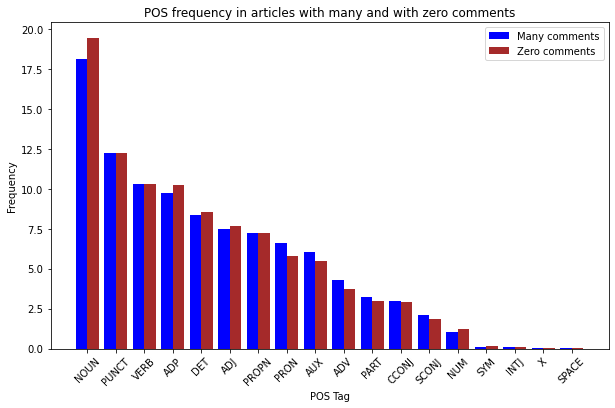

In [48]:
# plotting the two dictionaries, side by side
pos_list = list(many_pos_norm_sorted.keys())

many_freq = [many_pos_norm_sorted.get(pos, 0) for pos in pos_list]
zero_freq = [zero_pos_norm_sorted.get(pos, 0) for pos in pos_list]
all_freq = many_freq + zero_freq

plt.figure(figsize=(10, 6))
bar_width = 0.4
index = np.arange(len(pos_list))

pos_with_labels = [pos + "_1" for pos in pos_list] + [pos + "_2" for pos in pos_list]

plt.bar(index, many_freq, bar_width, color='blue', label='Many comments')
plt.bar(index + bar_width, zero_freq, bar_width, color='brown', label='Zero comments')

plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.title('POS frequency in articles with many and with zero comments')
plt.xticks(index + bar_width / 2, pos_list, rotation=45)
plt.legend()
plt.show()

## Defining functions

A lot of what we have done above we have done for two different things, the many and the zero comment articles. That felt tedious, because we were just copy-pasting the same information, only changing the name of some variables. For that kind of situation, creating a generic function is much more efficient. 

Let's look at the `count_pos()` function. We define it using `def`. Then, we give it an argument, the doc (spaCy object) that contains our corpus processed by spaCy. 

Then, we do exactly the same thing we did above: we count the pos tags, we add up how many there are and sort that dictionary. At the end, the function prints the total number of POS tags and the list (a dictionary, really).

To use the function, we simply call it with the right doc object. So, if we want to count the POS in many_comments, we pass that argument. And the same for zero comments. 

In [49]:
def count_pos(doc):
    
    pos_counts = {}
    pos_total = 0
    
    for token in doc:
        pos_tag = token.pos_
        pos_counts[pos_tag] = pos_counts.get(pos_tag, 0) + 1
        pos_total = pos_total + 1
        
    pos_counts_sorted = dict(sorted(pos_counts.items(), key = lambda item: item[1], reverse = True))
    
    return pos_counts_sorted

To "call" this function, that is, to use this function, you simply type the name of the function and pass the variable that contains your corpus. Recall that this is `many_doc` and `zero_doc`, from above, the two docs that we produced with spaCy.

In [50]:
count_pos(many_doc)

{'NOUN': 15291,
 'PUNCT': 10351,
 'VERB': 8661,
 'ADP': 8206,
 'DET': 7046,
 'ADJ': 6309,
 'PROPN': 6108,
 'PRON': 5589,
 'AUX': 5091,
 'ADV': 3602,
 'PART': 2696,
 'CCONJ': 2527,
 'SCONJ': 1769,
 'NUM': 886,
 'SYM': 85,
 'INTJ': 58,
 'X': 36,
 'SPACE': 19}

Now, that only prints the dictionary from many_doc. If you want to store that dictionary to use later, then you assign it to a variable. This variable is exactly the same as the `many_pos_counts_sorted` above, but we produced it through a much more efficient way; that's why I'm calling it "better". And you can do the same for the `zero_doc`. 

In [51]:
many_pos_counts_sorted_better = count_pos(many_doc)

In [52]:
zero_pos_counts_sorted_better = count_pos(zero_doc)

In [53]:
many_pos_counts_sorted_better

{'NOUN': 15291,
 'PUNCT': 10351,
 'VERB': 8661,
 'ADP': 8206,
 'DET': 7046,
 'ADJ': 6309,
 'PROPN': 6108,
 'PRON': 5589,
 'AUX': 5091,
 'ADV': 3602,
 'PART': 2696,
 'CCONJ': 2527,
 'SCONJ': 1769,
 'NUM': 886,
 'SYM': 85,
 'INTJ': 58,
 'X': 36,
 'SPACE': 19}

In [54]:
zero_pos_counts_sorted_better

{'NOUN': 14701,
 'PUNCT': 9247,
 'VERB': 7780,
 'ADP': 7740,
 'DET': 6459,
 'ADJ': 5796,
 'PROPN': 5486,
 'PRON': 4394,
 'AUX': 4161,
 'ADV': 2845,
 'PART': 2246,
 'CCONJ': 2204,
 'SCONJ': 1398,
 'NUM': 945,
 'SYM': 108,
 'INTJ': 63,
 'X': 30,
 'SPACE': 4}

# Your turn!

Try it! Define a new function that doesn't do raw counts, but normalized counts, something like:

`def pos_count_norm(doc):`

Then you can probably turn most of the things we did twice, for many and for zero, into functions that you can reuse. 